# Winning Jeopardy
In this project, we will work with a dataset of Jeopardy questions to figure out some patterns in the questions that could help you win.

The dataset is named jeopardy.csv, and contains 20000 rows from the beginning of a full dataset of Jeopardy questions, which you can download [here](https://www.reddit.com/r/datasets/comments/1uyd0t/200000_jeopardy_questions_in_a_json_file/).

Each row in the dataset represents a single question on a single episode of Jeopardy. Here are explanations of each column:

* Show Number -- the Jeopardy episode number of the show this question was in.
* Air Date -- the date the episode aired.
* Round -- the round of Jeopardy that the question was asked in. Jeopardy has several rounds as each episode progresses.
* Category -- the category of the question.
* Value -- the number of dollars answering the question correctly is worth.
* Question -- the text of the question.
* Answer -- the text of the answer.

In [98]:
import pandas as pd
import numpy as np
import re
import random
import matplotlib.pyplot as plt
%matplotlib inline

## Load and  clean the data
We perform the following operations:
* Load the data
* Rename columns by setting to lowercase and substituting spaces by underscores
* Convert Value to float removing the $ symbols
* Convert Air Date to datetime
* Normalize text in Questions and Answers: send to lowercase and remove punctuation.

In [48]:
# Load the data
jeopardy = pd.read_csv('jeopardy.csv')
# Rename the columns
dic_col = {col:re.sub(r'\s+','_', col.strip()).lower() for col in jeopardy.columns}
jeopardy.rename(columns=dic_col, inplace=True)
jeopardy.columns

Index(['show_number', 'air_date', 'round', 'category', 'value', 'question',
       'answer'],
      dtype='object')

In [49]:
# Convert the value column to float (in dollars). There are None values, 
# we send them to $0 instead. Assign the values to cleaned_value
jeopardy['clean_value'] = jeopardy['value'].str.replace(r'None','$0')
jeopardy['clean_value'] = jeopardy['clean_value'].str.replace(r'$','').str.replace(r',','')
jeopardy['clean_value'] = pd.to_numeric(jeopardy['clean_value'])

jeopardy['clean_value'].head()

0    200
1    200
2    200
3    200
4    200
Name: clean_value, dtype: int64

In [50]:
# Convert air_date from string to datetime
jeopardy['air_date'] = pd.to_datetime(jeopardy['air_date'])
jeopardy.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 19999 entries, 0 to 19998
Data columns (total 8 columns):
show_number    19999 non-null int64
air_date       19999 non-null datetime64[ns]
round          19999 non-null object
category       19999 non-null object
value          19999 non-null object
question       19999 non-null object
answer         19999 non-null object
clean_value    19999 non-null int64
dtypes: datetime64[ns](1), int64(2), object(5)
memory usage: 1.2+ MB


In [51]:
# Send answers to lower case and remove punctuation
def normalize_text(s):
    snew = s.copy()
    snew = snew.str.lower()
    snew = snew.str.replace(r'[^\w\s]','')
    return snew

# Clean question and answer columns, and assign to 
# clear_question and clear_answer columns
jeopardy['clean_question'] = normalize_text(jeopardy['question'])
jeopardy['clean_answer'] = normalize_text(jeopardy['answer'])
jeopardy.head()

,show_number,air_date,round,category,value,question,answer,clean_value,clean_question,clean_answer
0,4680,2004-12-31,Jeopardy!,HISTORY,$200,"For the last 8 years of his life, Galileo was ...",Copernicus,200,for the last 8 years of his life galileo was u...,copernicus
1,4680,2004-12-31,Jeopardy!,ESPN's TOP 10 ALL-TIME ATHLETES,$200,No. 2: 1912 Olympian; football star at Carlisl...,Jim Thorpe,200,no 2 1912 olympian football star at carlisle i...,jim thorpe
2,4680,2004-12-31,Jeopardy!,EVERYBODY TALKS ABOUT IT...,$200,The city of Yuma in this state has a record av...,Arizona,200,the city of yuma in this state has a record av...,arizona
3,4680,2004-12-31,Jeopardy!,THE COMPANY LINE,$200,"In 1963, live on ""The Art Linkletter Show"", th...",McDonald's,200,in 1963 live on the art linkletter show this c...,mcdonalds
4,4680,2004-12-31,Jeopardy!,EPITAPHS & TRIBUTES,$200,"Signer of the Dec. of Indep., framer of the Co...",John Adams,200,signer of the dec of indep framer of the const...,john adams


## Analyze the data
We want to answer the following questions:
* How often the answer is deducible from the question (Overlap bbetween question and answer).
* How often new questions are repeats of older questions (Overlap between old questions).

We can answer the second question by seeing how often complex words (> 6 characters) reoccur. We can answer the first question by seeing how many times words in the answer also occur in the question. 

### Overlap between questions and answers

In [55]:
def answer_question_match(s):
    # split answer and question. We remove 'the' word from answers
    split_answer = s['clean_answer'].replace('the', '').split()
    split_question = s['clean_question'].split()
    
    # discard answers with length 0
    if len(split_answer)==0:
        return 0
    # count the appearences of an answer word in the question
    match_count = 0
    for word in split_answer:
        if word in split_question:
            match_count += 1
    # normalize the counts to the answer length
    answer_in_question = match_count/len(split_answer)
    return answer_in_question

jeopardy['answer_in_question'] = jeopardy.apply(answer_question_match, axis=1)
print('The mean of answer_in_question: {0}'.format(jeopardy['answer_in_question'].mean()))
jeopardy['answer_in_question'].value_counts(normalize=True)

The mean of answer_in_question: 0.057955758538287654


0.000000    0.876294
0.500000    0.071254
0.333333    0.024801
0.250000    0.007200
1.000000    0.006200
0.666667    0.005350
0.200000    0.003350
0.400000    0.001150
0.166667    0.001150
0.142857    0.000950
0.750000    0.000600
0.125000    0.000350
0.285714    0.000300
0.600000    0.000300
0.111111    0.000150
0.428571    0.000150
0.300000    0.000100
0.800000    0.000100
0.875000    0.000050
0.100000    0.000050
0.444444    0.000050
0.133333    0.000050
0.181818    0.000050
Name: answer_in_question, dtype: float64

As we see most of the times (88%) there is no overlap between the answer and the question. In a 7% there is 0.5 overlap and in a 2% there is 1/3 overlap. The mean overlap between answer in question is a 6%, rather small. Therefore we claim that it is not very helpful the text in the question to automatically deduce the answer, since the overlap is small.

### Overlap between questions through jeopardy history
Here in our analysis we decide to reject words with length < 6, as they likely do not contain specific information regarding the question, i.e. they are not "complex words".

In [61]:
# We sort the dataframe by air_date chronologically from older to newer, 
# this way we see how the usage of terms repeats through time
jeopardy = jeopardy.sort_values(by='air_date', ascending=True)
jeopardy.head()

,show_number,air_date,round,category,value,question,answer,clean_value,clean_question,clean_answer,answer_in_question
19325,10,1984-09-21,Final Jeopardy!,U.S. PRESIDENTS,None,"Adventurous 26th president, he was 1st to ride...",Theodore Roosevelt,0,adventurous 26th president he was 1st to ride ...,theodore roosevelt,0.0
19285,10,1984-09-21,Jeopardy!,GEOGRAPHY,$300,"8th most populous country in the world, this ""...",Bangladesh,300,8th most populous country in the world this be...,bangladesh,0.0
19324,10,1984-09-21,Double Jeopardy!,TV TRIVIA,$1000,"In court, he'd always make mincemeat of Hamilt...",Perry Mason,1000,in court hed always make mincemeat of hamilton...,perry mason,0.0
19301,10,1984-09-21,Double Jeopardy!,LABOR UNIONS,$200,Notorious labor leader missing since '75,Jimmy Hoffa,200,notorious labor leader missing since 75,jimmy hoffa,0.0
19302,10,1984-09-21,Double Jeopardy!,1789,$200,"Washington proclaimed Nov. 26, 1789 this first...",Thanksgiving,200,washington proclaimed nov 26 1789 this first n...,thanksgiving,0.0


In [83]:
# iterate from older to newer questions keeping track of
# the "complex" (length >= 6 characters) terms which repeat 
# we store the percentage of repeating terms comapared to older
# appearences of the terms.
question_overlap = []
terms_used = set()
for index, row in jeopardy.iterrows():
    match_count = 0
    # split question strings into words
    split_question_raw = row['clean_question'].split()
    split_question = []
    for word in split_question_raw:
        # descard words shorter than 6 and add word to terms_used
        # if it was not there yet
        if len(word) >= 6:
            split_question.append(word)
            if word in terms_used:
                match_count += 1
            else:
                terms_used.add(word)
    # append the normalized (divided by number oif words in the question) 
    # matches to question_overlap list. Neglect cases where length = 0.
    if len(split_question)==0:
        match_count = 0
    else:
        match_count = match_count/len(split_question)
    question_overlap.append(match_count)
jeopardy['question_overlap'] = pd.Series(question_overlap, index=jeopardy.index)     

Percentage of questions with less than 0,5 overlap: 17.6158807940397%


1.000000    0.306215
0.500000    0.110156
0.666667    0.098505
0.000000    0.079704
0.750000    0.079004
0.800000    0.062053
0.600000    0.045802
0.833333    0.040502
0.333333    0.036652
0.857143    0.022951
Name: question_overlap, dtype: float64

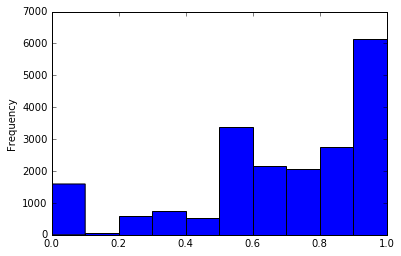

In [95]:
jeopardy['question_overlap'].plot.hist()
less_half_overlap = (jeopardy['question_overlap']<0.5).sum()/jeopardy['question_overlap'].shape[0]
print('Percentage of questions with less than 0,5 overlap: {0}%'.format(less_half_overlap*100))
jeopardy['question_overlap'].value_counts(normalize=True).head(10)

We see that a 30% of the questions are identically repeated, whereas only a 17% of all the questions have less than a 0.5 overlap. We set as 0,5 overlap as the threshold to determine it to be a different question. Hence, we conclude that in geopardy the best way to prepare for competing is byu studying all the older questions.

### Finding out the words with the highest impact on the value
Here now we proceed to estimate the probabilities of words in terms_used to appear, together with High or Low value of the question. The High/Low value category is defined as Value lower or equal/higher than ¤800.

To determine which are the words that affect the most the value, we compute the chi-squared for a subset of words, and choose the ones with the highest ch-squared value associated.

In [115]:
def classify_by_value(row):
    if row['clean_value'] > 800:
        value = 1
    else :
        value = 0
    return value

def word_counts_in_high_low_questions(word, df):
    low_count = 0
    high_count = 0
    for index, row in df.iterrows():
        # split question strings into words
        split_question_raw = row['clean_question'].split()
        if word in split_question_raw:
            if row['high_value'] :
                high_count += 1
            else:
                low_count += 1
    return high_count, low_count

# classify into high and low value the questions
jeopardy['high_value'] = jeopardy.apply(classify_by_value,axis=1)

# select 10 random words from terms_used
comparison_terms = random.sample(terms_used, 100)

# append the high/low_counts associated to each word to 
# the list observed_expected
observed_expected = []
for word in comparison_terms:
    high_low_values = word_counts_in_high_low_questions(word, jeopardy)
    observed_expected.append(high_low_values)

In [116]:
observed_expected

[(0, 1),
 (1, 12),
 (1, 0),
 (1, 4),
 (0, 1),
 (0, 1),
 (3, 16),
 (0, 1),
 (1, 0),
 (1, 1),
 (1, 3),
 (0, 2),
 (1, 0),
 (1, 0),
 (0, 1),
 (0, 1),
 (8, 9),
 (0, 1),
 (1, 4),
 (1, 0),
 (12, 44),
 (0, 1),
 (0, 1),
 (1, 0),
 (1, 1),
 (0, 1),
 (2, 3),
 (1, 0),
 (2, 8),
 (0, 1),
 (0, 1),
 (0, 1),
 (0, 1),
 (1, 0),
 (0, 1),
 (5, 19),
 (1, 0),
 (3, 8),
 (0, 1),
 (0, 1),
 (3, 3),
 (7, 13),
 (0, 1),
 (1, 1),
 (0, 1),
 (0, 1),
 (2, 2),
 (2, 2),
 (1, 0),
 (0, 2),
 (0, 1),
 (0, 1),
 (3, 5),
 (0, 1),
 (0, 4),
 (1, 0),
 (0, 1),
 (0, 1),
 (1, 0),
 (0, 1),
 (0, 1),
 (0, 1),
 (0, 1),
 (1, 1),
 (0, 1),
 (1, 0),
 (1, 0),
 (0, 1),
 (0, 1),
 (3, 3),
 (1, 0),
 (0, 1),
 (1, 0),
 (1, 0),
 (0, 4),
 (1, 0),
 (1, 0),
 (1, 1),
 (0, 1),
 (1, 0),
 (0, 1),
 (1, 0),
 (4, 10),
 (3, 9),
 (0, 1),
 (1, 0),
 (0, 1),
 (1, 1),
 (1, 0),
 (0, 2),
 (0, 1),
 (1, 1),
 (1, 4),
 (0, 1),
 (1, 2),
 (0, 2),
 (0, 1),
 (2, 1),
 (0, 1),
 (0, 1)]

In [125]:
from scipy.stats import chisquare
# Calculate the chi-squared associated to the distribution
high_value_count = (jeopardy['high_value']==1).sum()
low_value_count = (jeopardy['high_value']==0).sum()

chi_squared = []
for high_counts, low_counts in observed_expected:
    total = high_counts + low_counts
    total_prop = total/jeopardy.shape[0]
    high_expected = total_prop*high_value_count 
    low_expected = total_prop*low_value_count
    chisq, pval = chisquare([high_counts, low_counts], 
                            [high_expected, low_expected])
    chi_squared.append(pval)

In [129]:
pd.Series(chi_squared).describe()

count    100.000000
mean       0.411741
std        0.214677
min        0.093652
25%        0.137886
50%        0.526077
75%        0.526077
max        0.993398
dtype: float64

As we see, there is no statistically relevant relation between the random sample of words and the value of the question. Of course, in our case, most of the words are mentioned only once or twice in our dataset, and fir such low counts the chi-squared test is not relevant. We coul instead choose only words with a minimum of mentions in our dataset and repeat this test

## Conclusions
In this project we analyzed the questions and answers from 20 years of the jeopardy quiz, and found out the following:
* As much as 83% of the questions seem to repeat, or overlap with previous questions.
* The overlap between questions and answers is rather small ~10%, and therefore we e